# SuperMarioBot: Using Deep Q-Learning to Play Super Mario Bros. (Columbia University MA Stats GR5242: Advanced Machine Learning Final Project Report)

## Contributors

* Sam Kolins (sk3651)
* Atishay Sehgal (as5453)
* Arpita Shah (as5451)

## Project Implementation: SuperMarioBot (5xConv AV-Stream Network)

### Installation

In [ ]:
# note: this entire notebook was created LOCALLY in Python 3.6.6 because Colab has issues running gym-super-mario-bros

# for me:
# to access, open Anaconda Prompt and type "activate py36" followed by "jupyter notebook"
# it might only need to be done once
# does not need to be done on the desktop because I made sure to install Anaconda3 5.2.0 which has Python 3.6 by default

# in console: "python -m pip install --upgrade pip" after "activate py36" to enter the Python 3.6 notebook
# start by installing the package
!pip install gym-super-mario-bros

When running the starter code, I had some missing DLL errors from trying to import `cv2` (which is a dependency used by either `nes_py` or `gym_super_mario_bros`), so installing the following package might help if you get the same issues. If not, I would recommend installing [Dependency Walker](http://dependencywalker.com/), which is free, which I ran on the `.pyd` file for my version of `cv2` to determine which dependencies I was missing and thereby manually downloaded them.

In [6]:
# I had some missing DLL errors from trying to import cv2, so installing this might help if you have the same issues
# if not, you might have to look for the missing DLL's manually. there's a free program called Dependency Walker that can help
# locate missing DLL's
!pip install opencv-contrib-python

In [35]:
# install Tensorboard if needed for visualization
!pip install Tensorboard

We mentioned earlier that the NES controller has eight buttons. Because any combination of inputs can be registered on a single frame, that means there are $2^8 = 256$ possible NES controller inputs possible on a given frame. But *Super Mario Bros.* fails to make use of most of them; as discussed earlier, the **Select** and **Start** buttons (and even **up** and **down**) are highly niche buttons within the game, and because this emulation lacks a title screen (as there is no reason to train on it), we never need to press **Start** or **Select**. This seems like it would an extremely wasteful use of this action space, but luckily, `gym_super_mario_bros` contains three action libraries. One of these is `SIMPLE_MOVEMENT`, which contains the following seven inputs: **idle**, **right**, **right+A**, **right+B**, **right+A+B**, **A**, and **left**. `COMPLEX_MOVEMENT` adds button combinations that involve the direction **left** while `RIGHT_ONLY` removes any non-idle action that does not move Mario to the right.

Why might Mario ever want to move left? He may want to dodge enemies or go back to get missed coins or power-ups, but there is a more pertinent use case here. Mario may be forced to enter a pipe that opens sideways, in which case if it is possible to jump on that pipe and keep moving forward past the opening like it is at [the end of World 1-2](https://www.mariowiki.com/images/f/fb/World_1-2_SMB.png), Mario is very likely to get stuck running into the wall unless he learns to move left.

In [1]:
# packages needed for the rest of the project, except for gym_super_mario_bros stuff (in the next code block)
# if you get a FutureWarning message about "np.floating" being deprecated or something, ignore it

from __future__ import division
from keras.models import Model
from keras.layers import Conv2D, Dense, Flatten, Input, Lambda
from keras.callbacks import TensorBoard
import keras.backend as K

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# run this to allow Keras to save model weights
# it should just run automatically because h5py is a dependency of Keras by default
import h5py
import os # also need this to create the path

C:\Users\Sam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# run this block if you just want to import without seeing the demo of Mario doing random stuff for 5000 steps
# if you haven't seen that yet, you should!
from nes_py.wrappers import BinarySpaceToDiscreteSpaceEnv
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

In [3]:
# run this for the RIGHT_ONLY Mario training periods (see Training Period 6 near the end of the report)
from gym_super_mario_bros.actions import RIGHT_ONLY

In [12]:
# initializing an environment in which Mario chooses a random action from the SIMPLE_MOVEMENT action library for 5000 steps
# on the default Mario ROM's, there is a frameskip factor of 4 frames, so one step is really more like 4 frames

from nes_py.wrappers import BinarySpaceToDiscreteSpaceEnv
import gym_super_mario_bros
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
env = gym_super_mario_bros.make('SuperMarioBros-v2')
env = BinarySpaceToDiscreteSpaceEnv(env, SIMPLE_MOVEMENT)

done = True
for step in range(5000):
    if done:
        state = env.reset()
    state, reward, done, info = env.step(env.action_space.sample())
    env.render()

env.close()

Whether you try to run the demo or not, there's one important takeaway: when acting completely randomly, Mario has a hard time clearing [this pipe section](https://i.imgur.com/J4SHXL6.png) near the beginning of the level, because Mario either fails to randomly succeed in jumping over the pipes before the time limit is reached or he touches a Goomba and dies. This is the first serious challenge a random algorithm has when facing World 1-1 and it is the first challenge that we would like to learn to surpass using a deep $Q$-learning network.

### Building the Network

In [4]:
# we can start to actually implement the deep Q-network (DQN) now

class CNN_DQNAgent():
    def __init__(self, input_shape, num_actions, final_layer_size = 128):
        # The input image of Super Mario Bros. is 256x240x3 (RGB color channels)
        # but env.observation_space.shape = (240, 256, 3), so for whatever reason it's flipping the images
        # either that or I'm somehow wrong about the dimension conventions for gym_super_mario_bros/nes_py
        # we will have to account for this in our model
        self.inputs = Input(shape = input_shape, name = "main_input")
        
        # 5 convolutional layers (with relu activation) on the input
        # Conv1: 32 filters, 24x24 with 4x4 striding
        self.model = Conv2D(filters = 32, kernel_size = [24, 24], strides = [4, 4], 
                            activation = "relu", padding = "valid", name = "conv1")(self.inputs)
        # Conv2: 64 filters, 13x17 with 2x2 striding
        # the rectangular filters here are designed to make the output square (not counting depth of course)
        self.model = Conv2D(filters = 64, kernel_size = [13, 17], strides = [2, 2], 
                            activation = "relu", padding = "valid", name = "conv2")(self.model)
        # Conv3: 64 filters, 12x12 no striding (1x1)
        self.model = Conv2D(filters = 64, kernel_size = [12, 12], strides = [1, 1], 
                            activation = "relu", padding = "valid", name = "conv3")(self.model)
        # Conv4: 128 filters, 8x8 no striding
        self.model = Conv2D(filters = 128, kernel_size = [8, 8], strides = [1, 1], 
                            activation = "relu", padding = "valid", name = "conv4")(self.model)
        # Conv5: 128 (final_layer_size) filters, 4x4 no striding
        self.model = Conv2D(filters = final_layer_size, kernel_size = [4, 4], strides = [1, 1], 
                            activation = "relu", padding = "valid", name = "conv5")(self.model)
        # output size is now 1x1x128 with 1,884,576 trainable parameters
        
        # the final conv layer is separated into value and advantage streams
        # value stream: current value in a given state
        # advantage stream: change in value after making a particular move
        # Advantage(state, action) = Q(state, action) - Value(state)
        self.stream_AC = Lambda(lambda layer: layer[:, :, :, :final_layer_size // 2], 
                                name = "adv_stream")(self.model)
        self.stream_VC = Lambda(lambda layer: layer[:, :, :, final_layer_size // 2:], 
                                name = "val_stream")(self.model)
        
        # flatten the advantage and value functions
        self.stream_AC = Flatten(name = "adv_flat")(self.stream_AC)
        self.stream_VC = Flatten(name = "val_flat")(self.stream_VC)
        
        # define weights for advantage and value layers
        # these will be trained so that the matmul matches the expected adv/val from play
        self.Advantage = Dense(num_actions, name = "final_advantage")(self.stream_AC)
        self.Value = Dense(1, name = "final_value")(self.stream_VC)
        
        # add value and advantage to get Q-output
        # advantage is evaluated based on how good the action is relative to average state adv
        self.model = Lambda(lambda val_adv: val_adv[0] + (val_adv[1] - K.mean(val_adv[1], axis = 1, keepdims = True)),
                           name = "final_out")([self.Value, self.Advantage])
        self.model = Model(self.inputs, self.model)
        self.model.compile("adam", "mse")
        self.model.optimizer.lr = 0.0001 # learning rate

In [5]:
# Q-network setup
main_qn = CNN_DQNAgent(input_shape = (240, 256, 3), num_actions = len(RIGHT_ONLY), final_layer_size = 128)
target_qn = CNN_DQNAgent(input_shape = (240, 256, 3), num_actions = len(RIGHT_ONLY), final_layer_size = 128)
# len(SIMPLE_MOVEMENT) = 7
# len(RIGHT_ONLY) = 5
# len(COMPLEX_MOVEMENT) = 12

# running a summary call to confirm my parameter calculations are correct
main_qn.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
main_input (InputLayer)         (None, 240, 256, 3)  0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 55, 59, 32)   55328       main_input[0][0]                 
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 22, 22, 64)   452672      conv1[0][0]                      
__________________________________________________________________________________________________
conv3 (Conv2D)                  (None, 11, 11, 64)   589888      conv2[0][0]                      
__________________________________________________________________________________________________
conv4 (Con

### Experience Replay Buffer, Parameters, Helper Function

Now, we wish to implement an ***experience replay system*** that stores game experiences. This too is represented as an instance of a class, this time called `ExperienceReplay`. To train from the network, we sample a batch of these from the trove of game experiences we have collected. We also cycle out older experiences for newer, more relevant ones past a certain limit defined here by `buffer_size`. Again, Blagojevic's tutorial was very helpful here.

In [6]:
class ExperienceReplay:
    def __init__(self, buffer_size = 50000):
        """ Data structure used to hold experiences """
        # each element of buffer contains a list: [state, action, reward, next_state, done]
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self, experience):
        """ Adds list of experiences to the buffer """
        # extend stored experiences
        self.buffer.extend(experience)
        # keep last buffer_size number of experiences
        self.buffer = self.buffer[-self.buffer_size:]
        # this construction better than using a control statement on current length of buffer
        
    def sample(self, size):
        """ Returns a sample of experiences from the buffer """
        sample_idxs = np.random.randint(len(self.buffer), size = size)
        sample_output = [self.buffer[idx] for idx in sample_idxs]
        sample_output = np.reshape(sample_output, (size, -1))
        return sample_output

As mentioned, we occasionally pull from `ExperienceReplay` to train the network. We then continue playing using the updated network after the weights have been changed. The **target network** is used to determine what the values should be based on the current state and action. In the next section, we will actually implement how training the main model is supposed to work, but first, we must initialize a host of useful parameters that will be used for training. Each line is commented with a brief description of what each variable represents.

In [7]:
# initializing useful parameters
batch_size = 64 # number of experiences used for each training step
num_epochs = 20 # number of epochs to train
update_freq = 4 # frequency of network updates
y = 0.99 # discount factor
prob_random_start = 0.9 # initial epsilon (chance of random action in epsilon-greedy policy)
prob_random_end = 0.3 # final epsilon
epsilon_steps = 290 # number of times epsilon decays from init -> final (should be = # of training episodes)
num_episodes = 300 # number of episodes to train; remember that one episode = 3 lives!
pre_train_episodes = 10 # number of episodes of random action (to build replay buffer)
max_num_step = 50000 # maximum episode length in units of steps
load_model = True # if True, will load a saved model
path = "./models" # path for saved model
main_weights_file = path + "/main_weights.h5" # file that will contain saved main weights
target_weights_file = path + "/target_weights.h5" # same, but for target weights
final_layer_size = 128 # size of final conv layer (before AV-stream split)
tau = 1 # rate to update target network toward primary network

# note: num_episodes - pre_train_episodes is number of training episodes

# if we wish to stop training after surpassing a certain mean reward, specify that goal here
# I'm leaving this commented out (and the print segment for surpassing the goal as well)
# because I don't yet have a sense of how much reward corresponds to, say, beating a level yet
# presumably, we could also read from the info dict returned by each step to detect for changes in level tuple
# goal = 10

Some useful notes:

* Remember that a single episode consists of three lives. Since we aren't accounting for changes in behavior based on the number of lives as that is not a part of the reward function (to be discussed later), our strategy is independent of the current life count, and so one-life episodes would be indistinguishable from three-life episodes. We haven't adjusted the *Super Mario Bros.* package to reflect this difference (although we could choose to load a single level if we wanted one-life episodes), but it does mean we can run on fewer episodes and still get good results. Choosing $333$ episodes, for example, as I have done here by default, still gets us $333 \times 3 = 999$ lives worth of training.
* This algorithm uses an $\epsilon$-greedy policy, but introduces an interesting variation in which $\epsilon$ will vary over time. Mario will therefore be fairly experimental in the earliest stages of the stage, trying a host of different options to collect as many game states as possible (to say nothing of the pre-training episodes in which Mario will only act randomly), but will be increasingly looking to optimize his reward over time.
* We want `max_num_step` to be very large. As you might have seen running a completely random sample of Mario actions a few code blocks ago, $5000$ steps is enough for an episode or two, but that's about it. Once Mario gets better at running through levels, each episode could be very long; we don't want to cut off too many potentially successful level completion runs early.
* The inclusion of `final_layer_size` is technically unnecessary as we have given it the default value of `128` when we were defining our network agent. Because it is important in determining the sizes of our advantage and value streams though, it feels like something that should technically be modifiable via changing a variable.

There is one more thing we need before we can start the actual training: a helper function called `update_target_graph`. This function updates the target graph `target_graph` with values from the main graph `main_graph` via a weighted average of the values in each graph. The weight for this average is determined by `tau`. For an example of how this might work, suppose `main_graph = [0, 1, 2]`, `target_graph = [3, 4, 5]`, and $\tau = 0.1$. Then the values updated to the target graph, written in matrix multiplication form, are

$$ \left[\begin{matrix}
0 & 3 \\
1 & 4 \\
2 & 5 \end{matrix}\right] \cdot \left[\begin{matrix}
\tau \\
1 - \tau \end{matrix}\right] = \left[\begin{matrix}
0 & 3 \\
1 & 4 \\
2 & 5 \end{matrix}\right] \cdot \left[\begin{matrix}
0.1 \\
0.9 \end{matrix}\right] = \left[\begin{matrix}
2.7 \\
3.7 \\
4.7 \end{matrix}\right]. $$

The function is not actually doing this as a matrix multiplication though, rather it is simply taking a weighted average for each entry, as in `[(0 * 0.1) + (3 * 0.9), (1 * 0.1) + (4 * 0.9), (2 * 0.1) + (5 * 0.9)] = [2.7, 3.7, 4.7]`. Note that we do not need to store these weights in any sort of variable; a simple call to `set_weights()` will calibrate them for us. Because we are not using TensorFlow, we do not need to save these into a tensor object and then make sure the session runs on this tensor object in addition to the rest of the graph. This is a nice convenience that the use of Keras grants to us.

The code for this won't be found on Blagojevic's tutorial. Instead, it can be found [on his GitHub here](https://github.com/breeko/Simple-Reinforcement-Learning-with-Tensorflow/blob/master/Part%204%20-%20Deep%20Q-Networks%20and%20Beyond%20with%20Keras.ipynb).

In [8]:
# helper function for updating target graph with values from main graph
def update_target_graph(main_graph, target_graph, tau):
    updated_weights = (np.array(main_graph.get_weights()) * tau) + (np.array(target_graph.get_weights()) * (1 - tau))
    target_graph.set_weights(updated_weights)

Now, we can actually start training.

### Training the Agent

*(Note: if you render the environment and it freezes every once in a while, that's just the deep Q-network going through the training motions. You'll know this because it will freeze periodically in precise accordance with the number of episodes it takes before the model decides to update again, saved to* `update_freq`*.)*

In [9]:
# (re)initializing the environment (we closed it before with env.close())
# or if you haven't seen the demo, this would be the first time you're running it
env = gym_super_mario_bros.make('SuperMarioBros-v2')
env = BinarySpaceToDiscreteSpaceEnv(env, RIGHT_ONLY)

In [10]:
# Reset everything
K.clear_session()

# Q-network setup
main_qn = CNN_DQNAgent(input_shape = env.observation_space.shape, 
                       num_actions = len(RIGHT_ONLY), 
                       final_layer_size = final_layer_size)
target_qn = CNN_DQNAgent(input_shape = env.observation_space.shape, 
                         num_actions = len(RIGHT_ONLY), 
                         final_layer_size = final_layer_size)
# len(SIMPLE_MOVEMENT) = 7
# len(RIGHT_ONLY) = 5

# Make the networks equal
update_target_graph(main_qn.model, target_qn.model, 1)

# experience replay setup; where episodes are stored and grabbed for learning
experience_replay = ExperienceReplay()

# implementing epsilon variable with decay
# in the beginning, Mario will act almost completely randomly (completely random = pre-training)
# but over time, we will reduce the chance of random action in exchange for maximizing reward via Q function
prob_random = prob_random_start
prob_random_drop = (prob_random_start - prob_random_end) / epsilon_steps

# more variables real quick
num_steps = [] # tracks step count per episode
rewards = [] # tracks rewards per episode
total_steps = 0 # tracks cumulative steps taken during training
print_every = 1 # how often episode progress gets printed
save_every = 10 # how often we save
losses = [0] # tracks training losses
mean_losses = [] # tracks mean losses per num_epochs (per print_every episodes) 

episodeID = 0 # episode number

# path setup for saving
if not os.path.exists(path):
    os.makedirs(path)

# load weights if they are present
if load_model == True:
    if os.path.exists(main_weights_file):
        print("Loading main weights...")
        main_qn.model.load_weights(main_weights_file)
    if os.path.exists(target_weights_file):
        print("Loading target weights...")
        main_qn.model.load_weights(target_weights_file)
        
while episodeID < num_episodes:
    
    """ Get ready to run another episode! """
    
    # create experience replay for current episode
    episode_buffer = ExperienceReplay()
    
    # get game state from the environment
    state = env.reset()
    
    done = False # is game complete?
    sum_rewards = 0 # running sum of rewards in episode
    cur_step = 0 # running number of steps in episode
    
    while cur_step < max_num_step and not done:
        # render the environment (this is entirely optional)
        # commenting out may lead to faster train times but you won't be able to visualize progress
        env.render()
        
        # increment step counter
        cur_step += 1
        total_steps += 1
        
        if np.random.rand() < prob_random or episodeID < pre_train_episodes:
            # act randomly if Unif[0,1] < epsilon or if we are still in the pre-training phase
            action = env.action_space.sample()
        else:
            # Q network decides what action to take
            action = np.argmax(main_qn.model.predict(np.array([state])))
            
        # take action and advance the step, receiving next state/reward/done
        next_state, reward, done, _ = env.step(action)
        
        # episode setup for storage in replay buffer
        episode = np.array([[state], action, reward, [next_state], done])
        episode = episode.reshape(1, -1)
        
        # store the experience in the episode buffer
        episode_buffer.add(episode)
        
        # update cumulative rewards total
        sum_rewards += reward
        
        # update the state
        state = next_state
        
    """ After enough episodes, we train the network... """
        
    if episodeID > pre_train_episodes:
        if prob_random > prob_random_end:
            # decrease probability of random action
            prob_random -= prob_random_drop
            
        if episodeID % update_freq == 0:
            for epoch in range(num_epochs):
                # remember: train batch is a list of [S, A, R, S', done] lists...
                train_batch = experience_replay.sample(batch_size)
                
                # separate batch into components
                train_state, train_action, train_reward, train_next_state, train_done = train_batch.T
                
                # convert action array to int array for indexing
                train_action = train_action.astype(np.int)
                
                # stack states for learning
                train_state = np.vstack(train_state)
                train_next_state = np.vstack(train_next_state)
                
                # predicted action from main Q network
                target_q = target_qn.model.predict(train_state)
                
                # Q values from our target network for the next state
                target_q_next_state = main_qn.model.predict(train_next_state)
                train_next_state_action = np.argmax(target_q_next_state, axis = 1)
                train_next_state_action = train_next_state_action.astype(np.int)
                
                # if we have a Game Over, we don't want to train on that step
                # rewards will be multiplied by this value to ensure they aren't trained on
                train_gameover = train_done == 0
                
                # Q value of next state based on predicted action
                train_next_state_values = target_q_next_state[range(batch_size), train_next_state_action]
                
                # reward from action chosen in the training batch
                true_reward = train_reward + (y * train_next_state_values * train_gameover)
                target_q[range(batch_size), train_action] = true_reward
                
                # train the main model
                loss = main_qn.model.train_on_batch(train_state, target_q)
                losses.append(loss)
                
            # use main model to update target model
            update_target_graph(main_qn.model, target_qn.model, tau)
            
            if (episodeID + 1) % save_every == 0:
                # save the model
                main_qn.model.save_weights(main_weights_file)
                target_qn.model.save_weights(target_weights_file)
                
    # increment the episode (current episode is now finished)
    episodeID += 1
    
    # dump episodic replay buffer into global replay buffer
    # also, record number of steps and reward amount for that episode
    experience_replay.add(episode_buffer.buffer)
    num_steps.append(cur_step)
    rewards.append(sum_rewards)
    
    """ Lastly, we need an indication of current progress. So, we print after every 50 (print_every) episodes... """
    
    if episodeID % print_every == 0:
        mean_loss = np.mean(losses[-(print_every * num_epochs):])
        mean_losses.append(mean_loss)
        
        print("Episode: {}/{}, Mean reward: {:0.4f}, Epsilon: {:0.4f}, Loss: {:0.4f}". format(
            episodeID, num_episodes, np.mean(rewards[-print_every:]), prob_random, mean_loss))
        # if np.mean(rewards[-print_every:]) >= goal:
        #    print("Training complete!")
        #    break

# close the environment (make sure to reinitialize it with the previous code block if you want to train on loaded weights!)
env.close()

Episode: 1/300, Mean reward: 2331.0000, Epsilon: 0.9000, Loss: 0.0000
Episode: 2/300, Mean reward: 1936.0000, Epsilon: 0.9000, Loss: 0.0000
Episode: 3/300, Mean reward: 1442.0000, Epsilon: 0.9000, Loss: 0.0000
Episode: 4/300, Mean reward: 2169.0000, Epsilon: 0.9000, Loss: 0.0000
Episode: 5/300, Mean reward: 1547.0000, Epsilon: 0.9000, Loss: 0.0000
Episode: 6/300, Mean reward: 1851.0000, Epsilon: 0.9000, Loss: 0.0000
Episode: 7/300, Mean reward: 2254.0000, Epsilon: 0.9000, Loss: 0.0000
Episode: 8/300, Mean reward: 2366.0000, Epsilon: 0.9000, Loss: 0.0000
Episode: 9/300, Mean reward: 1068.0000, Epsilon: 0.9000, Loss: 0.0000
Episode: 10/300, Mean reward: 1103.0000, Epsilon: 0.9000, Loss: 0.0000
Episode: 11/300, Mean reward: 1993.0000, Epsilon: 0.9000, Loss: 0.0000
Episode: 12/300, Mean reward: 1576.0000, Epsilon: 0.8979, Loss: 0.0000
Episode: 13/300, Mean reward: 2422.0000, Epsilon: 0.8959, Loss: 176.4207
Episode: 14/300, Mean reward: 1498.0000, Epsilon: 0.8938, Loss: 176.4207
Episode: 15

Episode: 117/300, Mean reward: 1108.0000, Epsilon: 0.6807, Loss: 2.8258
Episode: 118/300, Mean reward: 1080.0000, Epsilon: 0.6786, Loss: 2.8258
Episode: 119/300, Mean reward: 1075.0000, Epsilon: 0.6766, Loss: 2.8258
Episode: 120/300, Mean reward: 1745.0000, Epsilon: 0.6745, Loss: 2.8258
Episode: 121/300, Mean reward: 721.0000, Epsilon: 0.6724, Loss: 2.0737
Episode: 122/300, Mean reward: 1310.0000, Epsilon: 0.6703, Loss: 2.0737
Episode: 123/300, Mean reward: 1359.0000, Epsilon: 0.6683, Loss: 2.0737
Episode: 124/300, Mean reward: 911.0000, Epsilon: 0.6662, Loss: 2.0737
Episode: 125/300, Mean reward: 1493.0000, Epsilon: 0.6641, Loss: 1.8896
Episode: 126/300, Mean reward: 1999.0000, Epsilon: 0.6621, Loss: 1.8896
Episode: 127/300, Mean reward: 1272.0000, Epsilon: 0.6600, Loss: 1.8896
Episode: 128/300, Mean reward: 1105.0000, Epsilon: 0.6579, Loss: 1.8896
Episode: 129/300, Mean reward: 1096.0000, Epsilon: 0.6559, Loss: 2.3869
Episode: 130/300, Mean reward: 1030.0000, Epsilon: 0.6538, Loss: 2

Episode: 232/300, Mean reward: 1263.0000, Epsilon: 0.4428, Loss: 5.5854
Episode: 233/300, Mean reward: 699.0000, Epsilon: 0.4407, Loss: 5.7677
Episode: 234/300, Mean reward: 1496.0000, Epsilon: 0.4386, Loss: 5.7677
Episode: 235/300, Mean reward: 1441.0000, Epsilon: 0.4366, Loss: 5.7677
Episode: 236/300, Mean reward: 1082.0000, Epsilon: 0.4345, Loss: 5.7677
Episode: 237/300, Mean reward: 1543.0000, Epsilon: 0.4324, Loss: 7.3007
Episode: 238/300, Mean reward: 1153.0000, Epsilon: 0.4303, Loss: 7.3007
Episode: 239/300, Mean reward: 1509.0000, Epsilon: 0.4283, Loss: 7.3007
Episode: 240/300, Mean reward: 902.0000, Epsilon: 0.4262, Loss: 7.3007
Episode: 241/300, Mean reward: 1085.0000, Epsilon: 0.4241, Loss: 5.9450
Episode: 242/300, Mean reward: 1110.0000, Epsilon: 0.4221, Loss: 5.9450
Episode: 243/300, Mean reward: 1106.0000, Epsilon: 0.4200, Loss: 5.9450
Episode: 244/300, Mean reward: 1409.0000, Epsilon: 0.4179, Loss: 5.9450
Episode: 245/300, Mean reward: 720.0000, Epsilon: 0.4159, Loss: 5.

In [11]:
# One final save for the weights once we're done
main_qn.model.save_weights(main_weights_file)
target_qn.model.save_weights(target_weights_file)

In [12]:
# How many steps did we take in this run? Run this to find out!
total_steps

400176

## Visualization of Results

It's hard to get a sense of how well Mario is learning just by reading code output. Therefore, I've decided to supply a few plots to assist in this analysis.

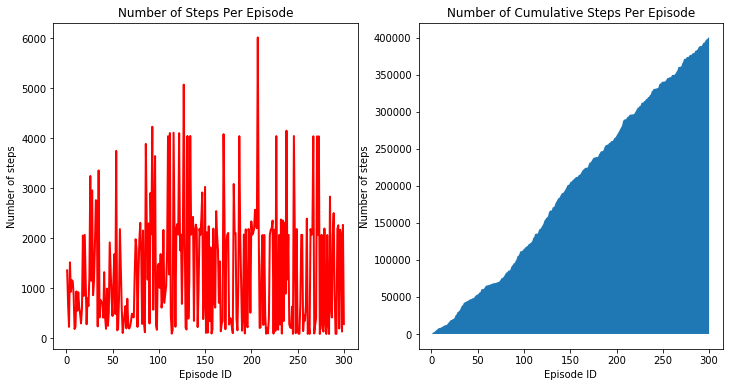

In [13]:
# plots of number of steps and number of cumulative steps per episode
x = list(range(1, num_episodes + 1))

fig = plt.figure(figsize = (12, 6))
fig.subplots_adjust(hspace = 6)

fig.add_subplot(1, 2, 1)
plt.plot(x, num_steps, color = "r", linewidth = 2)
plt.xlabel("Episode ID")
plt.ylabel("Number of steps")
plt.title("Number of Steps Per Episode")

fig.add_subplot(1, 2, 2)
plt.fill_between(x, np.cumsum(num_steps))
plt.xlabel("Episode ID")
plt.ylabel("Number of steps")
plt.title("Number of Cumulative Steps Per Episode")
plt.show()

In [14]:
# rolling average
s = pd.Series(rewards, index = range(1, 1 + num_episodes))
roll = s.rolling(window = 10).mean()

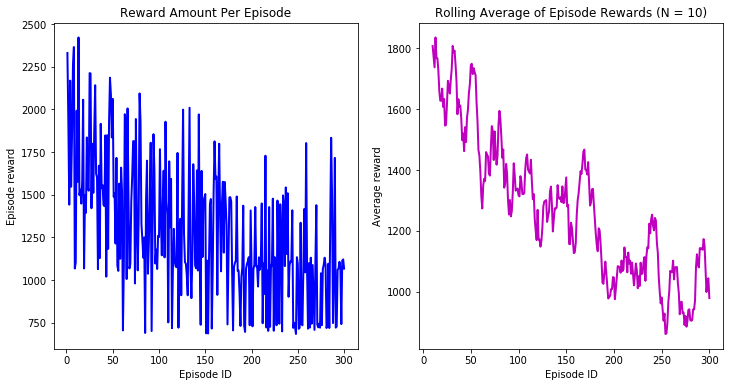

In [15]:
# plots of rewards and rolling average of rewards (window = 3) per episode
fig = plt.figure(figsize = (12, 6))
fig.subplots_adjust(hspace = 6)

fig.add_subplot(1, 2, 1)
plt.plot(x, rewards, color = "b", linewidth = 2)
plt.xlabel("Episode ID")
plt.ylabel("Episode reward")
plt.title("Reward Amount Per Episode")

fig.add_subplot(1, 2, 2)
plt.plot(x, list(roll), color = "m", linewidth = 2)
plt.xlabel("Episode ID")
plt.ylabel("Average reward")
plt.title("Rolling Average of Episode Rewards (N = 10)")
plt.show()

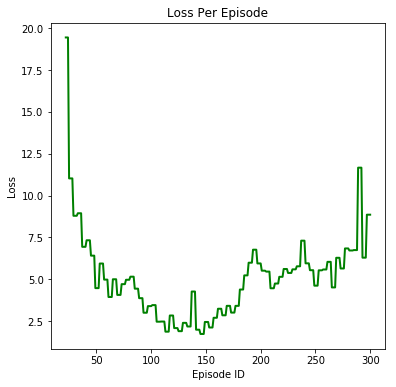

In [16]:
# plot of losses per episode
fig = plt.figure(figsize = (6, 6))
fig.add_subplot(1, 1, 1)
plt.plot(x[21:], mean_losses[21:], color = "g", linewidth = 2)
plt.xlabel("Episode ID")
plt.ylabel("Loss")
plt.title("Loss Per Episode")
plt.show()

[152.10345, 24.115452, 18.627913, 16.823278, 10.452521, 10.638659, 10.552846, 7.56521]
[0, 152.10345, 24.115452, 18.627913, 16.823278, 10.452521, 10.638659, 10.552846, 7.56521]


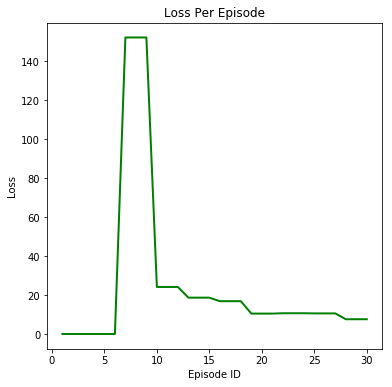

In [62]:
# YOU DON'T NEED TO RUN THIS CODE, I JUST INCLUDED IT FOR POSTERITY REASONS
# rolling mean losses for first trial, because I ran that trial before I saved the mean losses to a vector
roll_loss = []
for i in range(1, 9):
    roll_loss.append(np.mean(losses[:20*i+1][-(print_every * num_epochs):]))
print(roll_loss)
roll_loss = [0] + roll_loss
print(roll_loss)
roll_loss = np.repeat(roll_loss, np.insert(np.repeat(3, len(roll_loss) - 1), 0, 6))

fig = plt.figure(figsize = (6, 6))
fig.add_subplot(1, 1, 1)
plt.plot(x, roll_loss, color = "g", linewidth = 2)
plt.xlabel("Episode ID")
plt.ylabel("Loss")
plt.title("Rolling Mean Losses Per Episode")
plt.show()